In [1]:
import pandas as pd 
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway

warnings.filterwarnings('ignore')

# 시각화 환경
sns.set(style='whitegrid', palette='pastel')
plt.rcParams['font.family'] = 'Malgun Gothic'   
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def pre_process(df: pd.DataFrame) -> pd.DataFrame:
    '''
    데이터 전처리 함수
    - 결측치 처리, 데이터 타입 변환, 매핑, 파생변수 생성, 기본 지표 계산까지 수행
    Args:
        df (pd.DataFrame): 원본 데이터프레임
    Returns:
        pd.DataFrame: 전처리 완료된 데이터프레임
    '''

    # 1. 결측치 처리
    df['사업장_시도'] = df['사업장_시도'].fillna('미정')
    df['사업장_시군구'] = df['사업장_시군구'].fillna('미정')

    # 2. 기준년월 변환 (YYYYMM → PeriodIndex[월])
    df['기준년월'] = pd.to_datetime(df['기준년월'].astype(str), format='%Y%m', errors='coerce')
    df['기준년월'] = df['기준년월'].dt.to_period('M')  # "2024-12" 형태 유지

    # 3. 대구/경북 여부 플래그
    df['대구경북권_여부'] = df['사업장_시도'].isin(['대구광역시', '경상북도'])

    # 4. 전담고객여부 매핑 (Y/N → True/False)
    df['전담고객여부'] = df['전담고객여부'].map({'N': False, 'Y': True})

    # 5. 좌수 범주 → 숫자 매핑
    seat_map = {
        "0개": 0, "1개": 1, "2개": 2,
        "2개초과 5개이하": 4, "5개초과 10개이하": 8,
        "10개초과 20개이하": 15.5, "20개초과 30개이하": 25.5,
        "30개초과 40개이하": 35.5, "40개초과 50개이하": 45.5,
        "50개 초과": 55
    }
    cols_to_map = [
        "요구불예금좌수","거치식예금좌수","적립식예금좌수",
        "수익증권좌수","신탁좌수","퇴직연금좌수",
        "여신_운전자금대출좌수","여신_시설자금대출좌수","신용카드개수"
    ]
    df[cols_to_map] = df[cols_to_map].replace(seat_map)

    # 6. 거래건수 범주 → 숫자 매핑
    txn_map = {
        "0건": 0, "1건": 1, "2건": 2,
        "2건초과 5건이하": 3, "5건초과 10건이하": 7,
        "10건초과 20건이하": 15, "20건초과 30건이하": 25,
        "30건초과 40건이하": 35, "40건초과 50건이하": 45,
        "50건 초과": 60
    }
    cols_to_map = [
        "외환_수출실적거래건수","외환_수입실적거래건수",
        "창구거래건수","인터넷뱅킹거래건수","스마트뱅킹거래건수",
        "폰뱅킹거래건수","ATM거래건수","자동이체거래건수"
    ]
    df[cols_to_map] = df[cols_to_map].replace(txn_map)

    # 7. 파생 변수 생성
    df['총거래건수'] = df[['창구거래건수','인터넷뱅킹거래건수','스마트뱅킹거래건수',
                         '폰뱅킹거래건수','ATM거래건수','자동이체거래건수']].sum(axis=1)
    df['총잔액'] = df[['요구불예금잔액','거치식예금잔액','적립식예금잔액']].sum(axis=1)
    df['여신잔액'] = df[['여신_운전자금대출잔액','여신_시설자금대출잔액']].sum(axis=1)
    df['외환거래총금액'] = df[['외환_수출실적금액','외환_수입실적금액']].sum(axis=1)
    df['수탁상품총잔액'] = df[['수익증권잔액','신탁잔액','퇴직연금잔액']].sum(axis=1)
    df['카드사용총금액'] = df[['신용카드사용금액','체크카드사용금액']].sum(axis=1)

    # 8. 여신이용률
    df['여신이용률'] = np.where(df['여신한도금액'] == 0, 0, df['여신잔액'] / df['여신한도금액'])

    # 9. 디지털 거래건수 & 비중
    df['디지털거래건수'] = df[['인터넷뱅킹거래건수','스마트뱅킹거래건수',
                            '폰뱅킹거래건수','자동이체거래건수']].sum(axis=1)

    def calc_digital_ratio(row: pd.Series) -> float:
        if row['총거래건수'] == 0:
            return 0.0 if row['디지털거래건수'] == 0 else pd.NA
        return row['디지털거래건수'] / row['총거래건수']

    df['디지털비중'] = df.apply(calc_digital_ratio, axis=1)

    # 10. 창구비중, 요구불회전율
    df['창구비중'] = np.where(df['총거래건수'] == 0, 0, df['창구거래건수'] / df['총거래건수'])
    df['요구불회전율'] = np.where(df['요구불예금잔액'] == 0, 0,
                               (df['요구불입금금액'] + df['요구불출금금액']) / df['요구불예금잔액'])

    # 11. 수치형 컬럼 강제 변환
    cols_numeric = ['여신이용률','디지털비중','창구비중','요구불회전율']
    for col in cols_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 12. 예대마진 계산
    loan_rate = 0.05
    deposit_rate = 0.02
    df["예대마진"] = (df["여신_운전자금대출잔액"] + df["여신_시설자금대출잔액"]) * loan_rate \
                   - df["총잔액"] * deposit_rate

    return df

In [3]:
df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\Project\\Analysis of corporate data\\cor_data.csv", encoding='cp949')
pre_process(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347299 entries, 0 to 347298
Data columns (total 58 columns):
 #   Column       Non-Null Count   Dtype    
---  ------       --------------   -----    
 0   기준년월         347299 non-null  period[M]
 1   업종_대분류       347299 non-null  object   
 2   업종_중분류       347299 non-null  object   
 3   사업장_시도       347299 non-null  object   
 4   사업장_시군구      347299 non-null  object   
 5   법인_고객등급      347299 non-null  object   
 6   전담고객여부       347299 non-null  bool     
 7   요구불예금잔액      347299 non-null  float64  
 8   거치식예금잔액      347299 non-null  float64  
 9   적립식예금잔액      347299 non-null  float64  
 10  수익증권잔액       347299 non-null  float64  
 11  신탁잔액         347299 non-null  float64  
 12  퇴직연금잔액       347299 non-null  float64  
 13  여신한도금액       347299 non-null  float64  
 14  여신_운전자금대출잔액  347299 non-null  float64  
 15  여신_시설자금대출잔액  347299 non-null  float64  
 16  외환_수출실적금액    347299 non-null  float64  
 17  외환_수입실적금액    347299 non-null 

In [4]:
product_cols = [
    '요구불예금잔액', '거치식예금잔액', '적립식예금잔액',
    '수익증권잔액', '신탁잔액', '퇴직연금잔액',
    '여신_운전자금대출잔액', '여신_시설자금대출잔액',
    '외환_수출실적금액', '외환_수입실적금액'
]

df = df.copy()
for col in product_cols:
    df[col + '_보유'] = (df[col] > 0).astype(int)

# 상품 보유 개수 (다양성 지수)
df['상품다양성'] = df[[c + '_보유' for c in product_cols]].sum(axis=1)

# 핵심상품 여부 (퇴직연금, 외환, 투자상품 등 포함 여부)
df['핵심상품보유'] = (
    (df['퇴직연금잔액_보유'] +
     df['외환_수출실적금액_보유'] +
     df['외환_수입실적금액_보유'] +
     df['수익증권잔액_보유']) > 0
).astype(int)

# ------------------------------------------------------
# 3) 고객군 분류
# ------------------------------------------------------
def classify_customer(row):
    if row['상품다양성'] >= 3 and row['핵심상품보유'] == 1:
        return '핵심고객군'
    elif row['상품다양성'] >= 1:
        return '잠재성장고객군'
    else:
        return '단일상품고객'

df['고객군'] = df.apply(classify_customer, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347299 entries, 0 to 347298
Data columns (total 71 columns):
 #   Column          Non-Null Count   Dtype    
---  ------          --------------   -----    
 0   기준년월            347299 non-null  period[M]
 1   업종_대분류          347299 non-null  object   
 2   업종_중분류          347299 non-null  object   
 3   사업장_시도          347299 non-null  object   
 4   사업장_시군구         347299 non-null  object   
 5   법인_고객등급         347299 non-null  object   
 6   전담고객여부          347299 non-null  bool     
 7   요구불예금잔액         347299 non-null  float64  
 8   거치식예금잔액         347299 non-null  float64  
 9   적립식예금잔액         347299 non-null  float64  
 10  수익증권잔액          347299 non-null  float64  
 11  신탁잔액            347299 non-null  float64  
 12  퇴직연금잔액          347299 non-null  float64  
 13  여신한도금액          347299 non-null  float64  
 14  여신_운전자금대출잔액     347299 non-null  float64  
 15  여신_시설자금대출잔액     347299 non-null  float64  
 16  외환_수출실적금액       3472

# 고객등급별 예대마진 차이가 있을까?


,mean,median,std,count
법인_고객등급,,,,
일반,16.831480,2.688,76.656833,95059
우수,26.881844,13.320,56.041135,110923
최우수,129.670702,60.000,1216.630815,141317


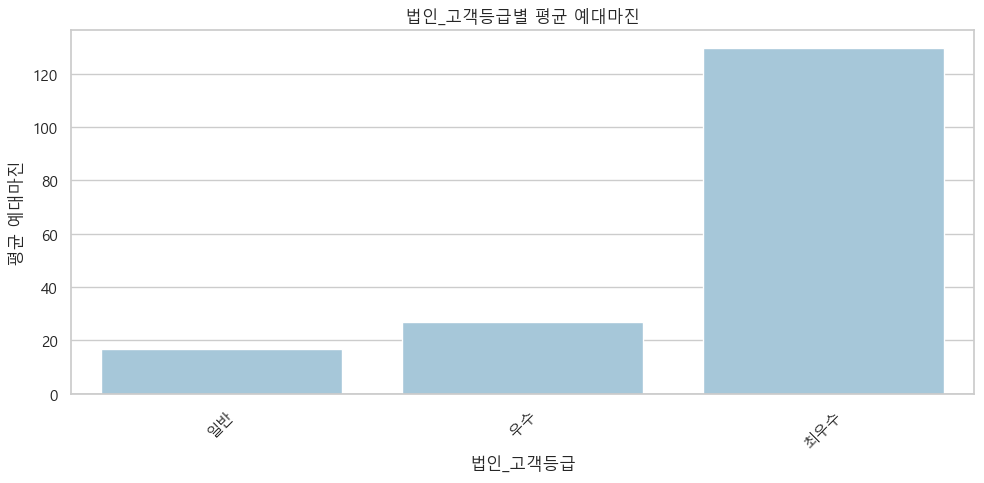

In [5]:
# 0) 안전 보정
if '법인_고객등급' not in df.columns or '예대마진' not in df.columns:
    raise KeyError("필수 컬럼(법인_고객등급, 예대마진) 누락")
df['예대마진'] = pd.to_numeric(df['예대마진'], errors='coerce')

# 1) 법인_고객등급별 예대마진 요약 (평균/중앙/분산)
nim_by_ind = (
    df.groupby('법인_고객등급', dropna=False)['예대마진']
      .agg(mean='mean', median='median', std='std', count='size')
      .sort_values('mean')
)
display(nim_by_ind)  # 법인_고객등급별 예대마진 요약 테이블

# 2) 시각화: 법인_고객등급별 평균 예대마진 Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=nim_by_ind.reset_index(),
    x='법인_고객등급', y='mean', color='#9ecae1'
)
plt.axhline(0, color='gray', lw=1)
plt.title('법인_고객등급별 평균 예대마진')
plt.xlabel('법인_고객등급')
plt.ylabel('평균 예대마진')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

고객등급별로 차이가 있는 것 같다.

이게 확실한 지 가설검증을 하자.

# 가설검정

데이터셋이 충분히 커서 정규성 검정은 안 해도됨

In [6]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway

In [7]:
groups = [g['예대마진'].values for _, g in df.groupby('법인_고객등급')]
lev_stat, lev_p = stats.levene(*groups, center='median')
print(f"Levene 등분산성 검정: W={lev_stat:.4f}, p={lev_p:.4g}")

Levene 등분산성 검정: W=1426.0371, p=0


등분산성 위배

Levene 위배 → Welch ANOVA로 전체 검정

In [8]:
from statsmodels.stats.oneway import anova_oneway

def welch_anova(df, dv="예대마진", group="법인_고객등급"):
    tmp = df[[dv, group]].dropna()
    y = pd.to_numeric(tmp[dv], errors="coerce").dropna().to_numpy()
    g = tmp.loc[tmp[dv].notna(), group].astype("category").to_numpy()

    res = anova_oneway(y, g, use_var="unequal", welch_correction=True)  # Welch ANOVA
    print(f"Welch ANOVA: F({res.df_num:.2f}, {res.df_denom:.2f})={res.statistic:.4f}, p={res.pvalue:.4g}")
    return res

# 사용 예
welch_anova(df, dv="예대마진", group="법인_고객등급")

Welch ANOVA: F(2.00, 206653.37)=1095.1750, p=0


<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(1095.1749512074568)
pvalue = np.float64(0.0)
df = (2.0, np.float64(206653.37395893573))
df_num = 2.0
df_denom = np.float64(206653.37395893573)
nobs_t = np.float64(347299.0)
n_groups = 3
means = array([ 26.88184386,  16.83147997, 129.67070196])
nobs = array([110923.,  95059., 141317.])
vars_ = array([   3140.60882619,    5876.27003496, 1480190.54091409])
use_var = 'unequal'
welch_correction = True
tuple = (np.float64(1095.1749512074568), np.float64(0.0))

 “Welch ANOVA 결과, 고객등급 간 예대마진 평균 차이가 통계적으로 유의하였다(F(df1, df2)=F, p<0.05).”

## 5️⃣ 종합 결론

등급별 차이는 통계적으로 매우 유의 (p<0.001)

**중앙값 기준으로 등급↑일수록 마진↑**  -> 일반 2.66 → 우수 13.00 (+10.34) → 최우수 57.58 (+44.58).

**평균도 상승하지만 최우수에서 점프 큼**  -> 16.77 → 26.60 (+9.83) → 114.53 (+87.93).

**평균–중앙값 괴리가 최우수에서 크게 확대**  ->  일반 +14.11, 우수 +13.60, 최우수 +56.95 → 꼬리(극단치) 영향 큼.

**변동성 폭증**  -> 표준편차: 일반 76.6, 우수 56.1, 최우수 1231.1 → 최우수 집단 이질성 매우 큼.

**표본수 충분**  -> 일반 95,059 / 우수 110,923 / 최우수 141,317 → 추정은 안정적이나, 최우수는 평균 대신 중앙값·절사평균으로 해석 권장.

등급이 높을수록 예대마진의 전형적 수준(중앙값)은 뚜렷이 높아지지만, 최우수 집단은 극단치가 많아 변동성이 매우 크다—따라서 최우수 평가는 평균치만으로 판단하지 말 것.

# 추가 분석 (손실 등급의 특징을 분석해보자)

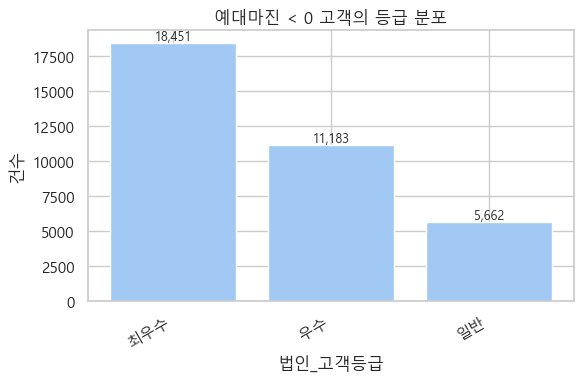

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 숫자화(문자/결측 방지)
tmp = df.copy()
tmp['예대마진'] = pd.to_numeric(tmp['예대마진'], errors='coerce')

# 필터: 예대마진 < 0
neg = tmp[tmp['예대마진'] < 0].copy()

# 등급 집계 (결측 등급은 '미지정'으로 표시)
grades = neg['법인_고객등급'].fillna('미지정').value_counts()

# 막대그래프
plt.figure(figsize=(6, 4))
plt.bar(grades.index.astype(str), grades.values)
plt.title('예대마진 < 0 고객의 등급 분포')
plt.xlabel('법인_고객등급')
plt.ylabel('건수')
plt.xticks(rotation=30, ha='right')

# 막대 위에 숫자 라벨
for i, v in enumerate(grades.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

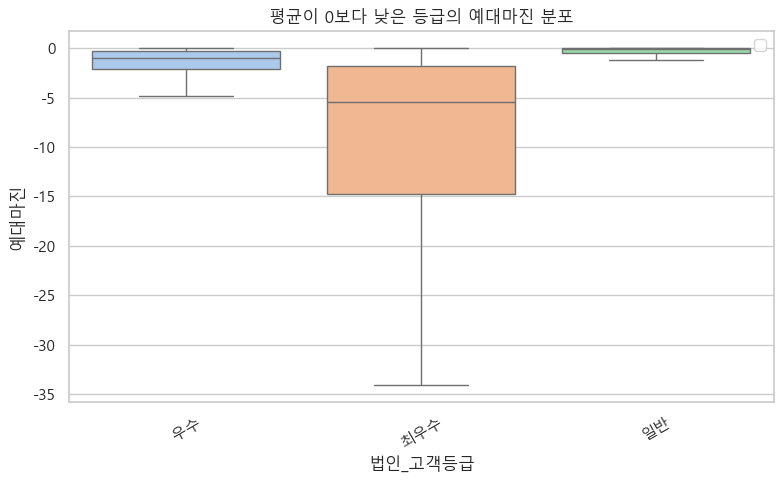

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=neg, x='법인_고객등급', y='예대마진', showfliers=False, palette="pastel")
plt.title("평균이 0보다 낮은 등급의 예대마진 분포")
plt.ylabel("예대마진")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

우리는 가설 1과 2를 통해 업종별·등급별로 고객들의 금융행동 차이를 확인했습니다.

가설 1에서는 손실 업종을 추가 분석하면서, 예대마진은 작지만 예금 규모가 큰 고객군을 발견했습니다.

가설 2에서는 최우수 고객군이 평균적으로는 예대마진이 높지만, 표준편차가 커서 이질적인 집단이라는 사실을 알게 됐습니다.

이 안에는 은행의 핵심 수익원이 될 만큼 고마진·고여신 고객도 있고,

반대로 음수 예대마진을 기록하면서 예금으로만 기여하는 고객도 있었습니다.

그래서 다음 단계에서는 최우수 고객군만 따로 뽑아 세분화를 진행할 계획입니다.


# 결론

최우수등급 중 평균 예대마진이 전담고객이 없는 세그먼트에서 낮게 나타남 - > RM 배정이 필요

RM이 있는데 예대마진이 음수인 최우수등급은 무엇?  => 상품다양성이 높음 1~9 (전담고객이 없는 세그먼트에서는 상품다양성이 1~6)

상품다양성이 높다고 